# core

> Fill in a module description here

In [1]:
#| default_exp vae

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from ts_vae_lstm.concepts import get_window
import os

In [4]:
num_workers = os.cpu_count()
num_workers

8

Train a VAE with no anomalies in the time series.

In [47]:
df = pd.read_csv('../sample_data/artificialNoAnomaly/artificialNoAnomaly/art_noisy.csv')
df.timestamp = pd.to_datetime(df.timestamp)
df.columns

Index(['timestamp', 'value'], dtype='object')

In [48]:
df["weekday"] = df.timestamp.apply(lambda x: dt.weekday(x))
df["hour"] = df.timestamp.apply(lambda x: x.hour)
df["week"] = df.timestamp.apply(lambda x: x.week)

In [49]:
df.tail(10)

,timestamp,value,weekday,hour,week
4022,2014-04-14 23:10:00,14.901829,0,23,16
4023,2014-04-14 23:15:00,14.228046,0,23,16
4024,2014-04-14 23:20:00,14.733648,0,23,16
4025,2014-04-14 23:25:00,14.041764,0,23,16
4026,2014-04-14 23:30:00,11.003317,0,23,16
4027,2014-04-14 23:35:00,10.689582,0,23,16
4028,2014-04-14 23:40:00,9.507657,0,23,16
4029,2014-04-14 23:45:00,17.339780,0,23,16
4030,2014-04-14 23:50:00,14.781273,0,23,16
4031,2014-04-14 23:55:00,10.051621,0,23,16


In [50]:
from scipy import signal

Smooth the signal as the noise is making it difficult to learn. Smooth over a window of 1 hour.

In [51]:
window_length_day = int(60/5)

In [52]:
df["value_original"] = df.value
df["value"] = signal.savgol_filter(df.value_original, window_length=window_length_day, polyorder=1)
df.value

0       13.085107
1       13.188385
2       13.291662
3       13.394940
4       13.498218
          ...    
4027    12.733610
4028    12.818560
4029    12.903511
4030    12.988461
4031    13.073411
Name: value, Length: 4032, dtype: float64

<Axes: >

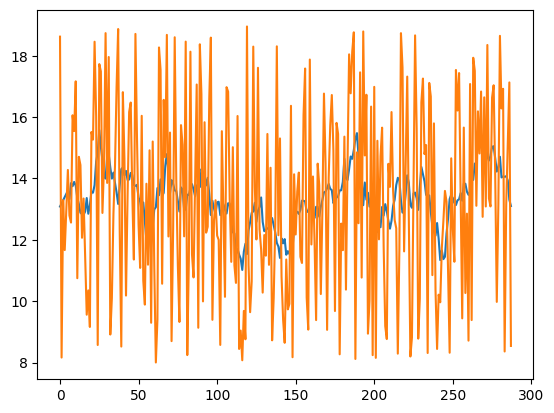

In [53]:
sns.lineplot(df.value.values[:288])
sns.lineplot(df.value_original.values[:288])

In [54]:
df.drop(columns=['value_original'], inplace=True)

In [55]:
df.columns

Index(['timestamp', 'value', 'weekday', 'hour', 'week'], dtype='object')

Prepare rolling windows of datasets, overlap is ok.

One time step delta is 5min

In [56]:
(288*5)/60

24.0

In [57]:
window_size = 288  # so that one window is one day

data = [{
    "subset": get_window(df.values, 
                         window_size=window_size, 
                         end_step=end_step, 
                         indices=list(df.index), 
                         return_indices=False),
    "end_step": end_step,
    "start_step": end_step-window_size,
} for end_step in range(window_size, len(df))]


In [58]:
# Number of datapoints
len(df)-window_size 

3744

Preseve 10% of the dataset from this for validation set.

In [59]:
val_data_idxs = np.random.choice(range(len(data)), size=int(0.1 * len(data)), replace=False)
trn_data_idxs = [idx for idx in range(len(data)) if idx not in val_data_idxs]
len(val_data_idxs), len(trn_data_idxs)

(374, 3370)

In [60]:
#| export
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch

In [61]:
val_data = [data[idx] for idx in val_data_idxs]
trn_data = [data[idx] for idx in trn_data_idxs]

Calculate stats over training data.

In [62]:
trn_data[0]['subset'].shape

(288, 5)

In [63]:
means = np.zeros((len(trn_data), 4))
stds = np.zeros((len(trn_data), 4)) 
for i, _trn_data in enumerate(trn_data):
    means[i] = (np.mean(_trn_data['subset'][:, 1:], axis=0)).astype(np.float32) 
    stds[i] = (np.var(_trn_data['subset'][:, 1:], axis=0)**0.5).astype(np.float32)  
means = means.mean(0)
stds = stds.mean(0)
means, stds

(array([13.49265649,  3.19205201, 11.5       , 14.61575791]),
 array([0.8906086 , 0.69736836, 6.92218637, 0.06091425]))

In [64]:
class TSDataset(Dataset):
    def __init__(self, data, mean, std):
        self.data = data 
        self.mean = mean
        self.std = std
    
    def __getitem__(self, idx):
        # output[channel] = (input[channel] - mean[channel]) / std[channel]
        x = self.data[idx]['subset'][:, 1:] # 1024, 4 
        normed_X = ((x - self.mean) / (self.std+1e-8)).astype(np.float32)
        return torch.as_tensor(normed_X)
    
    def __len__(self):
        return len(self.data)

In [65]:
dset_trn = TSDataset(trn_data, mean=means, std=stds)
dset_val = TSDataset(val_data, mean=means, std=stds)  # use same stats from training data 

In [66]:
dset_trn[0].shape

torch.Size([288, 4])

In [67]:
dl_trn = DataLoader(dataset=dset_trn, batch_size=100, drop_last=True, shuffle=True, num_workers=num_workers)
dl_val = DataLoader(dataset=dset_val, batch_size=100, drop_last=True, shuffle=False, num_workers=num_workers)

In [68]:
xs = next(iter(dl_trn))
xs.shape

torch.Size([100, 288, 4])

In [69]:
#| export

class StochasticSampler(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.z_space_distr = torch.distributions.Normal(loc=0, scale=1)
        
    def forward(self, z_mean, z_log_var): 
        # z_mean and z_log_var are mean and log-var estimates of the latent space
        # under the assumption that the latent space is a gaussian normal
        device = z_mean.device
        eps = self.z_space_distr.sample(z_mean.shape).to(device)
        return z_mean + torch.exp(0.5 * z_log_var) * eps

In [151]:
xs.shape, xs.reshape(100, -1).unsqueeze(1).shape

(torch.Size([100, 288, 4]), torch.Size([100, 1, 1152]))

In [171]:
xs_c1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3, 1))(xs.unsqueeze(1)) 
xs_c2 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 1), stride=(2, 1))(xs_c1)
xs_c3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 1), stride=(2, 1))(xs_c2)
xs_c4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 1), stride=(5, 1))(xs_c3)
xs_c5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 1), stride=(7, 1))(xs_c4)
xs_c1.shape, xs_c2.shape, xs_c3.shape, xs_c4.shape, xs_c5.shape

(torch.Size([100, 3, 286, 4]),
 torch.Size([100, 64, 142, 4]),
 torch.Size([100, 128, 70, 4]),
 torch.Size([100, 128, 14, 4]),
 torch.Size([100, 128, 2, 4]))

In [172]:
128*2*4

1024

In [175]:
#| export

class Encoder(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3, 1)) 
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 1), stride=(2, 1)) 
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 1), stride=(2, 1))
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 1), stride=(5, 1))
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 1), stride=(7, 1))
        # nn.Linear(in_features=window_size*4, out_features=512, bias=True)
        self.linear_mean = nn.Linear(in_features=1024, out_features=latent_dim, bias=True)
        self.linear_var = nn.Linear(in_features=1024, out_features=latent_dim, bias=True)
    
    def forward(self, x):
        x = x.unsqueeze(1) # 100, 1, 288, 4
        x = F.leaky_relu(self.conv1(x)) # 100, 3, 286, 4
        x = F.leaky_relu(self.conv2(x)) # 100, 64, 142, 4
        x = F.leaky_relu(self.conv3(x)) # 100, 128, 70, 4
        x = F.leaky_relu(self.conv4(x)) # 100, 128, 14, 4
        x = F.leaky_relu(self.conv5(x)) # 100, 128, 2, 4
        x = self.flatten(x) # 100, 1024
        z_mean = self.linear_mean(x)
        z_log_var = self.linear_var(x)
        return z_mean, z_log_var 


In [179]:
emb_mean, emb_var = Encoder()(xs)
emb = StochasticSampler()(emb_mean, emb_var)
emb_mean.shape, emb_var.shape, emb.unsqueeze(1).shape


(torch.Size([100, 20]), torch.Size([100, 20]), torch.Size([100, 1, 20]))

In [199]:
xs_c1 = nn.ConvTranspose2d(in_channels=1, out_channels=128, kernel_size=(3, 4))(emb.unsqueeze(1).unsqueeze(-1)) 
xs_c2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=(3, 1), stride=(2, 1))(xs_c1)
xs_c3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3, 1), stride=(2, 1))(xs_c2)
xs_c4 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=(3, 1), stride=(2, 1))(xs_c3)
xs_c5 = nn.ConvTranspose2d(in_channels=3, out_channels=1, kernel_size=(3, 1), stride=(2, 1))(xs_c4)
xs_c1.shape, xs_c2.shape, xs_c3.shape, xs_c4.shape, xs_c5.shape

(torch.Size([100, 128, 22, 4]),
 torch.Size([100, 128, 45, 4]),
 torch.Size([100, 64, 91, 4]),
 torch.Size([100, 3, 183, 4]),
 torch.Size([100, 1, 367, 4]))

In [202]:
#| export

class Decoder(nn.Module):
    def __init__(self, latent_dim=20, output_shape=(window_size, 4)):
        super().__init__() 
        self.dconv1 = nn.ConvTranspose2d(in_channels=1, out_channels=128, kernel_size=(3, 4))  
        self.dconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=(3, 1), stride=(2, 1)) 
        self.dconv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3, 1), stride=(2, 1)) 
        self.dconv4 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=(3, 1), stride=(2, 1)) 
        self.dconv5 = nn.ConvTranspose2d(in_channels=3, out_channels=1, kernel_size=(3, 1), stride=(2, 1)) 
        #self.linear1 = nn.Linear(in_features=latent_dim, out_features=512, bias=True)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=367*4, out_features=window_size*4, bias=True) 
        self.output_shape = output_shape
        
    def forward(self, x):
        x = x.unsqueeze(1).unsqueeze(-1)
        x = F.leaky_relu(self.dconv1(x)) 
        x = F.leaky_relu(self.dconv2(x)) 
        x = F.leaky_relu(self.dconv3(x)) 
        x = F.leaky_relu(self.dconv4(x)) 
        x = F.leaky_relu(self.dconv5(x)) 
        x = self.flatten(x)
        x = self.linear(x) 
        return self.reshape_to_output(x)
    
    def reshape_to_output(self, x):
        return x.reshape(-1, *self.output_shape)
    
    


In [205]:
Decoder()(emb).shape

torch.Size([100, 288, 4])

In [206]:
# | export
class VAE(nn.Module):
    def __init__(self, latent_dim=20, input_shape=(window_size, 4)):
        super().__init__() 
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, output_shape=input_shape)
        self.latent_sampler = StochasticSampler()
        
    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = self.latent_sampler(z_mean, z_log_var)
        out = self.decoder(z)
        # loss to enforce all possible values are sampled from latent space
        # should be of the size of the batch
        loss_kl = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp(), dim=1)
        return out, loss_kl

In [207]:
xs_pred, loss_kl = VAE()(xs)

In [208]:
#| export

def snr_loss(predicted_signal, target_signal):
    # Calculate the power of the target signal
    target_power = torch.mean(target_signal**2, dim=(1, 2))
    
    # Calculate the power of the noise (difference between predicted and target signals)
    noise_power = torch.mean((predicted_signal - target_signal)**2, dim=(1, 2))
    
    # Calculate SNR in dB (decibels)
    snr = 10 * torch.log10(target_power / noise_power)
    
    # The goal is to maximize SNR, so we negate it to create a loss function
    loss = -snr
    
    return loss


In [209]:
#| export 

def calculate_smape(predicted, actual):
    absolute_percentage_errors = (torch.abs(predicted - actual) / (torch.abs(predicted) + torch.abs(actual))) * 100
    smape = absolute_percentage_errors
    return smape


In [210]:
# | export

def loss_func(inputs, targets, loss_kl):
    # targets = torch.where(targets >= 0, 1., 0.)
    bs = inputs.shape[0]
    loss_reconstruct = F.huber_loss(inputs, targets, reduction='none').mean((1,2)) # loss only for the signal
    #loss_reconstruct = calculate_smape(inputs, targets).mean((1, 2))
    # should be of the size of the batch to add losses correctly
    # loss_kl of shape bs,
    # loss_reconstruct of shape bs,
    # print(loss_reconstruct.shape, loss_kl.shape)
    return torch.mean(loss_reconstruct + loss_kl)

In [211]:
loss_func(xs, xs_pred, loss_kl)

tensor(2.7674, grad_fn=<MeanBackward0>)

In [212]:
def get_similarity(inputs, targets):
    func = F.mse_loss
    with torch.no_grad(): 
        return func(inputs.flatten(), targets.flatten()) 

In [213]:
get_similarity(xs, xs_pred)

tensor(24.0607)

# Training loop

In [214]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [215]:
def validate_epoch(dls, criterion, scorer): 
    model.eval()
    running_loss = 0.0
    running_score = 0.0
    with torch.no_grad():
        for batch_idx, xs in enumerate(dls):
            # move to device
            xs = xs.to(device) 
            
            # Forward pass
            xs_gen, loss_kl = model(xs)

            loss = loss_func(xs_gen, targets=xs, loss_kl=loss_kl)
            # calc score
            score = scorer(xs_gen, targets=xs)

            running_loss += loss.item()
            running_score += score.item()
    return running_loss, running_score

In [217]:
train_dataloader = dl_trn
valid_dataloader = dl_val
model = VAE(latent_dim=20).to(device) # to make visualization easier, 2 latent dims

learning_rate = 1e-3
criterion = loss_func
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) 
scorer = get_similarity
# Training loop
num_epochs = 100
print_every = len(train_dataloader)

# Define LR scheduler 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       factor=0.9, patience=10, 
                                                       min_lr=1e-8, verbose=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_score = 0.0
    for batch_idx, xs in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        # move to device
        xs = xs.to(device) 
        
        # Forward pass
        xs_gen, loss_kl = model(xs)
        
        loss = loss_func(xs_gen, targets=xs, loss_kl=loss_kl)
        # calc score
        score = scorer(xs_gen, targets=xs)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_score += score.item()
        if (batch_idx + 1) % print_every == 0:
            val_loss, val_score = validate_epoch(valid_dataloader, criterion, scorer)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_dataloader)}], Trn Loss: {(running_loss / print_every):.6f}, Trn Score: {(running_score / print_every):.6f}, Val Loss: {(val_loss/len(valid_dataloader)):.6f}, Val Score: {(val_score/len(valid_dataloader)):.6f}')
            running_loss = 0.0
            running_score = 0.0
    # Step the LR scheduler
    scheduler.step(val_loss) # min the running_loss


Epoch [1/100], Batch [33/33], Trn Loss: 2.602401, Trn Score: 26.138780, Val Loss: 2.558086, Val Score: 31.605245
Epoch [2/100], Batch [33/33], Trn Loss: 2.519227, Trn Score: 31.220679, Val Loss: 2.550120, Val Score: 31.964788
Epoch [3/100], Batch [33/33], Trn Loss: 2.507706, Trn Score: 31.305590, Val Loss: 2.551598, Val Score: 31.996539
Epoch [4/100], Batch [33/33], Trn Loss: 2.518461, Trn Score: 31.414013, Val Loss: 2.549885, Val Score: 31.429936
Epoch [5/100], Batch [33/33], Trn Loss: 2.516722, Trn Score: 31.437253, Val Loss: 2.551597, Val Score: 31.942389
Epoch [6/100], Batch [33/33], Trn Loss: 2.519548, Trn Score: 31.420870, Val Loss: 2.549851, Val Score: 31.393286
Epoch [7/100], Batch [33/33], Trn Loss: 2.518013, Trn Score: 31.473394, Val Loss: 2.548187, Val Score: 32.115779


KeyboardInterrupt: 

# Inference

In [218]:
with torch.no_grad():
    xs_val = next(iter(valid_dataloader))
    xs_val_gen, loss_kl = model(xs_val)

In [219]:
xs_val_gen[1], xs_val[1]

(tensor([[-0.0287,  0.1769,  0.1151,  5.5932],
         [-0.0904,  0.1668,  0.1126,  5.5953],
         [-0.0517,  0.1711,  0.0946,  5.5975],
         ...,
         [-0.0240,  0.0943,  0.0993,  5.7753],
         [-0.0391,  0.0836,  0.0856,  5.7744],
         [ 0.0886,  0.0700,  0.0992,  5.7723]]),
 tensor([[  0.7697,  -1.7094,  -0.3612, -10.1086],
         [  0.0115,  -1.7094,  -0.3612, -10.1086],
         [ -0.0380,  -1.7094,  -0.3612, -10.1086],
         ...,
         [ -2.3156,  -0.2754,  -0.3612, -10.1086],
         [ -1.4915,  -0.2754,  -0.3612, -10.1086],
         [ -1.7859,  -0.2754,  -0.3612, -10.1086]]))

<Axes: >

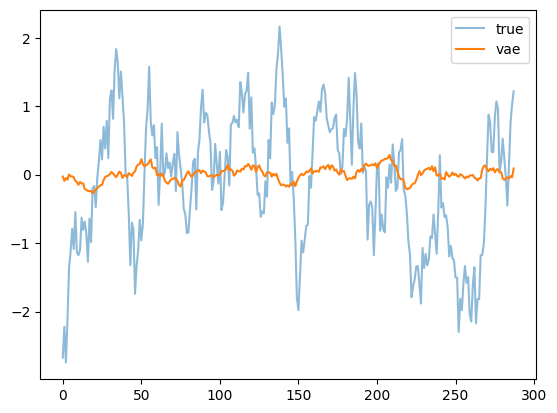

In [226]:
idx = 3
idx_feature = 0 
decoded_example, actual_example = xs_val_gen[idx], xs_val[idx] 
sns.lineplot(actual_example[:, idx_feature].numpy(), label='true', alpha=0.5)
sns.lineplot(decoded_example[:, idx_feature].numpy(), label='vae')

# Display embedding

In [227]:
with torch.no_grad():
    xs_val = next(iter(valid_dataloader))
    emb_mean_val, emb_std_val = model.encoder(xs_val)
    emb_val = model.latent_sampler(emb_mean_val, emb_std_val)

In [228]:
emb_val.numpy().shape

(100, 20)

<Axes: xlabel='None', ylabel='None'>

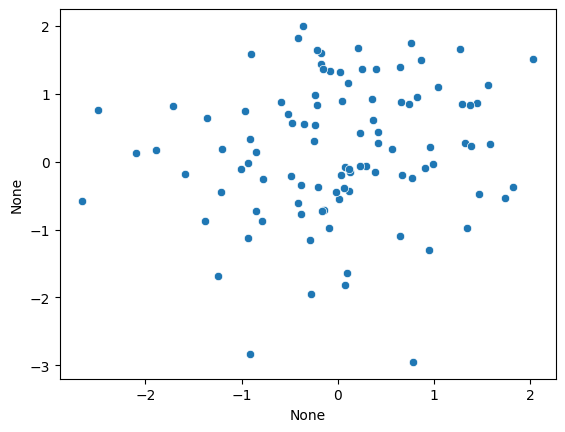

In [229]:
sns.scatterplot(x=emb_val[:, 0], y=emb_val[:, 1])

In [479]:
#| hide
import nbdev; nbdev.nbdev_export()